In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
BATCH_SIZE = 32
EPOCHS = 10

In [3]:
train_dataset = datasets.MNIST(root = './data/MNIST',
                              train = True, 
                              download = True,
                              transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = './data/MNIST',
                              train = False, 
                              transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST\MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\MNIST\raw



C:\ProgramData\Anaconda3\envs\testAI\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
for (X_train, y_train) in train_loader:
    print(X_train.size(), X_train.type())
    print(y_train.size(), y_train.type())
    break

torch.Size([32, 1, 28, 28]) torch.FloatTensor
torch.Size([32]) torch.LongTensor


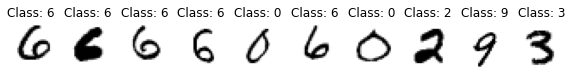

In [5]:
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = 'gray_r')
    plt.title('Class: ' + str(y_train[i].item()))

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [10]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [11]:
model = Net().to(DEVICE)

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

In [13]:
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [14]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, 
                batch_idx * len(image),
                len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), 
                loss.item()))

In [15]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [16]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, 
        test_loss, 
        test_accuracy))

C:\ProgramData\Anaconda3\envs\testAI\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.507232
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 2.417097
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 2.290214
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 2.411065
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 2.260670
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 2.318461
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 2.273409
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 2.320017
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 2.276499
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 2.342402

[EPOCH: 1], 	Test Loss: 2.2801, 	Test Accuracy: 10.28 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 2.349900
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 2.325243
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 2.272680
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 2.213304
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 2.253164
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 2.216505
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 2.137908
T

# Dropout + ReLU

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [18]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [19]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.282655
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 2.059322
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 1.116909
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.768995
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.625786
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.953076
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.515601
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.330348
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.392799
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.552184

[EPOCH: 1], 	Test Loss: 0.3200, 	Test Accuracy: 90.83 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.279926
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.974297
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.151935
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.201616
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.371803
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.408173
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.257237
T

# Dropout + ReLU + Batch Normalization

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)  # 첫 번째 Fully connected Layer
        self.fc2 = nn.Linear(512, 256)  # 두 번째 FCL
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512)  # 첫번째 Fully Connected Layer output이 512라서 512차원으로 설정
        self.batch_norm2 = nn.BatchNorm1d(256)  # 두 번째 FCL output 256

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.batch_norm1(x) # 활성함수 전/후 적용은 사람마다 선호가 다름
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [21]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [22]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.399780
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.574708
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.186143
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.304659
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.351856
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.526303
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.593846
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.724246
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.244152
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.337317

[EPOCH: 1], 	Test Loss: 0.1525, 	Test Accuracy: 95.53 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.183104
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.216719
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.156915
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.133826
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.299083
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.363306
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.765788
T

# Dropout + ReLU + Batch Normalization + He Uniform Initialization

In [23]:
import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)  # kaiming_uniform_ = He uniform
        
model = Net().to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [24]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [25]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.434592
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.641919
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.589326
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.472230
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.531813
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.513363
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.406553
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.245661
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.562303
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.216173

[EPOCH: 1], 	Test Loss: 0.1576, 	Test Accuracy: 95.04 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.263257
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.206747
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.415987
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.276957
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.180242
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.092399
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.196550
T

# Dropout + ReLU + Batch Normalization + He Uniform Initialization + Adam

In [26]:
import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)  # kaiming_uniform_ = He uniform
        
model = Net().to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [27]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [28]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.296063
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.322806
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.346818
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.344911
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.421797
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.397906
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.719169
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.400251
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.536445
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.512887

[EPOCH: 1], 	Test Loss: 0.1541, 	Test Accuracy: 95.32 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.138201
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.260345
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.079177
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.423420
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.251836
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.209662
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.384425
T

In [29]:
train_dataset = datasets.FashionMNIST(root = "./data/FashionMNIST",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root = "./data/FashionMNIST",
                                     train = False,
                                     transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)


Extracting ./data/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw




Extracting ./data/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw




Extracting ./data/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw




Extracting ./data/FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



In [30]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


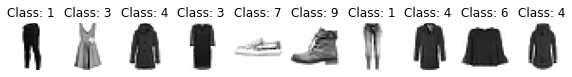

In [31]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))


In [32]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 32),)
        
        self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 28*28),)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [33]:
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [34]:
def train(model, train_loader, opimizer, log_interval):
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1, 28*28).to(DEVICE)
        target = image.view(-1, 28*28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [35]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    gen_image = []
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28 * 28).to(DEVICE)
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image)
            
            test_loss += criterion(decoded, image).item()
            real_image.append(image.to("cpu"))
            gen_image.append(decoded.to("cpu"))
            
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)

    return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 0.217069
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.031359
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.022251
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.021520
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.022088
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.018201
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.016355
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.017062
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.014622
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.014015

[EPOCH: 1], 	Test Loss: 0.0150


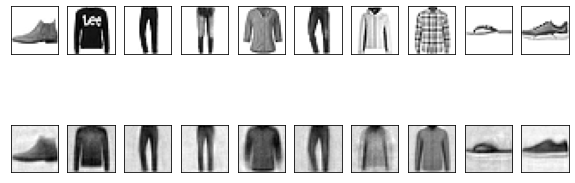

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.014639
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.014298
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.014095
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.014054
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.012799
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.012428
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.010945
Train Epoch: 2 [44800/60000 (75%)]	Train Loss: 0.012038
Train Epoch: 2 [51200/60000 (85%)]	Train Loss: 0.013579
Train Epoch: 2 [57600/60000 (96%)]	Train Loss: 0.012594

[EPOCH: 2], 	Test Loss: 0.0130


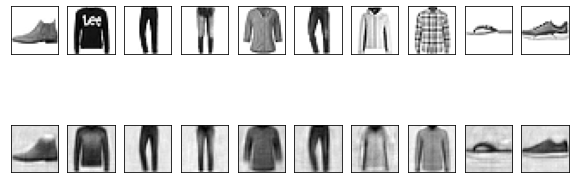

Train Epoch: 3 [0/60000 (0%)]	Train Loss: 0.014695
Train Epoch: 3 [6400/60000 (11%)]	Train Loss: 0.013254
Train Epoch: 3 [12800/60000 (21%)]	Train Loss: 0.012978
Train Epoch: 3 [19200/60000 (32%)]	Train Loss: 0.013206
Train Epoch: 3 [25600/60000 (43%)]	Train Loss: 0.011446
Train Epoch: 3 [32000/60000 (53%)]	Train Loss: 0.011064
Train Epoch: 3 [38400/60000 (64%)]	Train Loss: 0.010623
Train Epoch: 3 [44800/60000 (75%)]	Train Loss: 0.011645
Train Epoch: 3 [51200/60000 (85%)]	Train Loss: 0.010720
Train Epoch: 3 [57600/60000 (96%)]	Train Loss: 0.013196

[EPOCH: 3], 	Test Loss: 0.0116


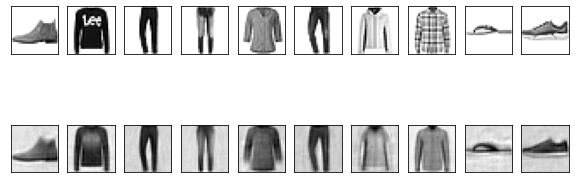

Train Epoch: 4 [0/60000 (0%)]	Train Loss: 0.012020
Train Epoch: 4 [6400/60000 (11%)]	Train Loss: 0.009802
Train Epoch: 4 [12800/60000 (21%)]	Train Loss: 0.014143
Train Epoch: 4 [19200/60000 (32%)]	Train Loss: 0.009752
Train Epoch: 4 [25600/60000 (43%)]	Train Loss: 0.011453
Train Epoch: 4 [32000/60000 (53%)]	Train Loss: 0.011053
Train Epoch: 4 [38400/60000 (64%)]	Train Loss: 0.012762
Train Epoch: 4 [44800/60000 (75%)]	Train Loss: 0.010528
Train Epoch: 4 [51200/60000 (85%)]	Train Loss: 0.010532
Train Epoch: 4 [57600/60000 (96%)]	Train Loss: 0.010969

[EPOCH: 4], 	Test Loss: 0.0115


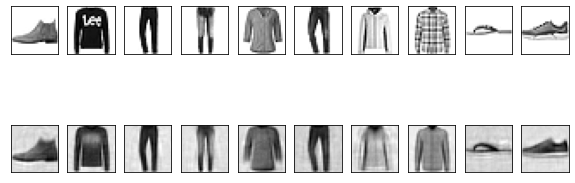

Train Epoch: 5 [0/60000 (0%)]	Train Loss: 0.012170
Train Epoch: 5 [6400/60000 (11%)]	Train Loss: 0.010640
Train Epoch: 5 [12800/60000 (21%)]	Train Loss: 0.010193
Train Epoch: 5 [19200/60000 (32%)]	Train Loss: 0.012147
Train Epoch: 5 [25600/60000 (43%)]	Train Loss: 0.013160
Train Epoch: 5 [32000/60000 (53%)]	Train Loss: 0.009806
Train Epoch: 5 [38400/60000 (64%)]	Train Loss: 0.011102
Train Epoch: 5 [44800/60000 (75%)]	Train Loss: 0.010993
Train Epoch: 5 [51200/60000 (85%)]	Train Loss: 0.011935
Train Epoch: 5 [57600/60000 (96%)]	Train Loss: 0.010474

[EPOCH: 5], 	Test Loss: 0.0108


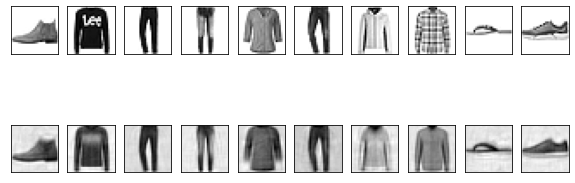

Train Epoch: 6 [0/60000 (0%)]	Train Loss: 0.010193
Train Epoch: 6 [6400/60000 (11%)]	Train Loss: 0.009232
Train Epoch: 6 [12800/60000 (21%)]	Train Loss: 0.009284
Train Epoch: 6 [19200/60000 (32%)]	Train Loss: 0.010246
Train Epoch: 6 [25600/60000 (43%)]	Train Loss: 0.010530
Train Epoch: 6 [32000/60000 (53%)]	Train Loss: 0.009583
Train Epoch: 6 [38400/60000 (64%)]	Train Loss: 0.010267
Train Epoch: 6 [44800/60000 (75%)]	Train Loss: 0.011530
Train Epoch: 6 [51200/60000 (85%)]	Train Loss: 0.012003
Train Epoch: 6 [57600/60000 (96%)]	Train Loss: 0.010409

[EPOCH: 6], 	Test Loss: 0.0104


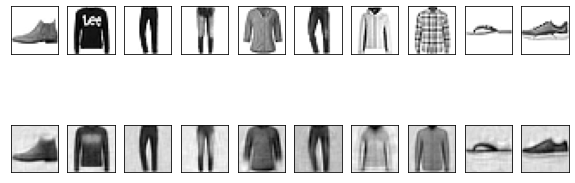

Train Epoch: 7 [0/60000 (0%)]	Train Loss: 0.009563
Train Epoch: 7 [6400/60000 (11%)]	Train Loss: 0.010369
Train Epoch: 7 [12800/60000 (21%)]	Train Loss: 0.009968
Train Epoch: 7 [19200/60000 (32%)]	Train Loss: 0.008882
Train Epoch: 7 [25600/60000 (43%)]	Train Loss: 0.011125
Train Epoch: 7 [32000/60000 (53%)]	Train Loss: 0.009687
Train Epoch: 7 [38400/60000 (64%)]	Train Loss: 0.010603
Train Epoch: 7 [44800/60000 (75%)]	Train Loss: 0.009048
Train Epoch: 7 [51200/60000 (85%)]	Train Loss: 0.010719
Train Epoch: 7 [57600/60000 (96%)]	Train Loss: 0.011033

[EPOCH: 7], 	Test Loss: 0.0102


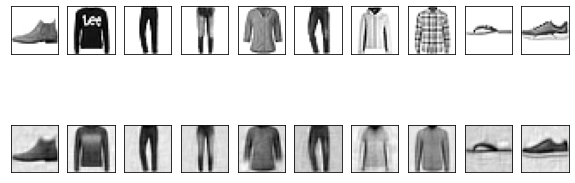

Train Epoch: 8 [0/60000 (0%)]	Train Loss: 0.012392
Train Epoch: 8 [6400/60000 (11%)]	Train Loss: 0.013387
Train Epoch: 8 [12800/60000 (21%)]	Train Loss: 0.010944
Train Epoch: 8 [19200/60000 (32%)]	Train Loss: 0.008952
Train Epoch: 8 [25600/60000 (43%)]	Train Loss: 0.010511
Train Epoch: 8 [32000/60000 (53%)]	Train Loss: 0.009381
Train Epoch: 8 [38400/60000 (64%)]	Train Loss: 0.009799
Train Epoch: 8 [44800/60000 (75%)]	Train Loss: 0.009290
Train Epoch: 8 [51200/60000 (85%)]	Train Loss: 0.010155
Train Epoch: 8 [57600/60000 (96%)]	Train Loss: 0.009390

[EPOCH: 8], 	Test Loss: 0.0101


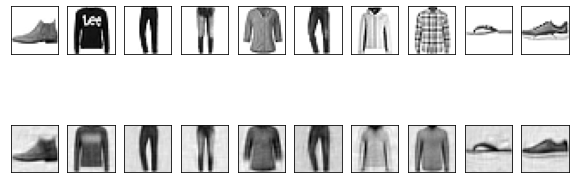

Train Epoch: 9 [0/60000 (0%)]	Train Loss: 0.012085
Train Epoch: 9 [6400/60000 (11%)]	Train Loss: 0.010101
Train Epoch: 9 [12800/60000 (21%)]	Train Loss: 0.010088
Train Epoch: 9 [19200/60000 (32%)]	Train Loss: 0.010742
Train Epoch: 9 [25600/60000 (43%)]	Train Loss: 0.007179
Train Epoch: 9 [32000/60000 (53%)]	Train Loss: 0.010908
Train Epoch: 9 [38400/60000 (64%)]	Train Loss: 0.009006
Train Epoch: 9 [44800/60000 (75%)]	Train Loss: 0.008731
Train Epoch: 9 [51200/60000 (85%)]	Train Loss: 0.008799
Train Epoch: 9 [57600/60000 (96%)]	Train Loss: 0.009543

[EPOCH: 9], 	Test Loss: 0.0099


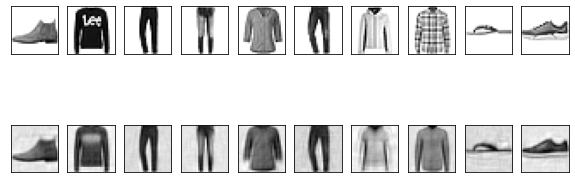

Train Epoch: 10 [0/60000 (0%)]	Train Loss: 0.009868
Train Epoch: 10 [6400/60000 (11%)]	Train Loss: 0.010067
Train Epoch: 10 [12800/60000 (21%)]	Train Loss: 0.009061
Train Epoch: 10 [19200/60000 (32%)]	Train Loss: 0.010044
Train Epoch: 10 [25600/60000 (43%)]	Train Loss: 0.007444
Train Epoch: 10 [32000/60000 (53%)]	Train Loss: 0.009343
Train Epoch: 10 [38400/60000 (64%)]	Train Loss: 0.008658
Train Epoch: 10 [44800/60000 (75%)]	Train Loss: 0.010741
Train Epoch: 10 [51200/60000 (85%)]	Train Loss: 0.008607
Train Epoch: 10 [57600/60000 (96%)]	Train Loss: 0.007651

[EPOCH: 10], 	Test Loss: 0.0098


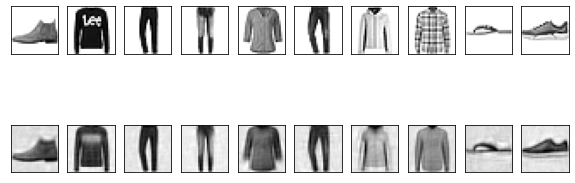

In [36]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()